In [1]:
#In this notebook, I am trying to show usage of Bert and how to fine tune.
#You can read explanation in medium. https://celikkam.medium.com/

In [2]:
import warnings
warnings.simplefilter('ignore')
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn import metrics
import transformers
import torch
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from transformers import DistilBertTokenizer, DistilBertModel
import logging
logging.basicConfig(level=logging.ERROR)

from transformers import BertTokenizer, BertModel, BertForMaskedLM
from scipy.spatial.distance import cosine
import torch
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics.pairwise import cosine_similarity
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
import matplotlib

In [3]:
#Bert utility methods to use in this tutorial. these methods are not optimized
#because it processes 1-by-1 , in real usage these methods must process multi-sentences at once


#Bert model returns 3 things : last_hidden_state, pooler_output, hidden_states
#last_hidden_state : last output of network [batch x seq_len x 768]
#pooler_output : the ouput of last piece of network [batch  x 768]
#hidden_states : all outputs of all layers(13 layers) each [batch x seq_len x 768]
def get_bert_output(tokenizer_,model_,sentence):
  bert_text = "[CLS] " + sentence + " [SEP]"
  tokenized_text = tokenizer_.tokenize(bert_text)
  indexed_tokens = tokenizer_.convert_tokens_to_ids(tokenized_text)
  segments_ids = [1] * len(tokenized_text)
  tokens_tensor = torch.tensor([indexed_tokens])
  segments_tensors = torch.tensor([segments_ids])
  
  outputs = model_(tokens_tensor, segments_tensors)
  return outputs  

#pooler is layer after transformers , use this output for classification tasks
#  (pooler): BertPooler(
#    (dense): Linear(in_features=768, out_features=768, bias=True)
#    (activation): Tanh()
#  )
def get_bert_output_pooled(tokenizer_,model_,sentence):  
  outputs = get_bert_output(tokenizer_,model_,sentence)
  output_pooled =  outputs["pooler_output"] 
  return output_pooled.squeeze()  

#last hidden state of CLS token represents sentence embedding
def get_bert_output_cls(tokenizer_,model_,sentence):    
  outputs = get_bert_output(tokenizer_,model_,sentence) 
  cls_output = outputs["last_hidden_state"].squeeze()[0]
  return cls_output


#hidden layers are 1 initial embedding + 12 bert tranformer = 13 layers
def get_bert_hidden_layers(tokenizer_,model_,sentence):
  outputs = get_bert_output(tokenizer_,model_,sentence)
  hidden_states = outputs["hidden_states"]
  return hidden_states  

#try different architectures that best fits your problem ,
#I can give combination of different layers and try which combination of hidden states best fit to
#your target problem
def get_sentence_embedding(tokenizer_,model_,sentence,layer_start=-4,layer_end=None,type="sumsum"):
  hidden_states = get_bert_hidden_layers(tokenizer_,model_,sentence)
  effective_layers = torch.stack(hidden_states[layer_start:layer_end])
  
  if type == "sumsum":
    sentence_embedding = torch.sum(effective_layers.sum(0).squeeze(), dim=0) 
  elif type == "summean":  
    sentence_embedding = torch.sum(effective_layers.mean(0).squeeze(), dim=0) 
  elif type == "meanmean":  
    sentence_embedding = torch.mean(effective_layers.mean(0).squeeze(), dim=0)    
  else:
    sentence_embedding = torch.mean(effective_layers.sum(0).squeeze(), dim=0)      

  return sentence_embedding



#all hidden transformer states
def get_bert_transformer_layers(tokenizer_,model_,sentence):  
  hidden_states = get_bert_hidden_layers(tokenizer_,model_,sentence)

  token_embeddings = torch.tensor( [h.detach().numpy() for h in hidden_states[1:]])
  token_embeddings = token_embeddings.squeeze()
  token_embeddings = token_embeddings.permute(1,0,2)
  return token_embeddings

 


#best practise is concating last 4 layers
#Steps to create a word embedding
#1) get all transformer layer outputs(12x768 for 1 word)
#2) do a summarization of 12 vector(mean,sum,pool,concat ...)
def get_word_embeddings_sum(tokenizer_,model_,sentence) :
  token_embeddings = get_bert_transformer_layers(tokenizer_,model_,sentence)  
  word_embeddings = []
  for token in token_embeddings:
    #torch.cat((token[-1], token[-2], token[-3], token[-4]), dim=0)        
    sum_vec = torch.sum(token[-4:], dim=0)   
    word_embeddings.append(sum_vec)

  return word_embeddings 

class EmbeddingPair:
  def __init__(self,word,vector):
    self.word = word
    self.vector = vector

#return token -> token_embedding as pairs.    
def get_embeddings_as_pair(tokenizer_,model_,sentence,embeddings):
  bert_text = "[CLS] " + sentence + " [SEP]"
  tokenized_text = tokenizer_.tokenize(bert_text)
  return [ EmbeddingPair(tokenized_text[index] , embeddings[index]) for index in range(len(tokenized_text)) ]


#given a sentence only return the embeddings of specified word
#just my utility method for easy visualization
def get_word_embeddings(tokenizer_,model_,sentence,word):
  embeddings = get_word_embeddings_sum(tokenizer_,model_, sentence )
  embeddings_as_pairs = get_embeddings_as_pair(tokenizer_,model_,sentence,embeddings)
  word_embeddings = []
  for pair in embeddings_as_pairs:
    if pair.word == word:
      word_embeddings.append( pair )
  return word_embeddings  

def get_similarity(vector1,vector2):
  return 1 - cosine(vector1, vector2)  
  
  






In [4]:



def map_on_3d(data_2d,words,color_mapping:None,exceptional_words=[],use_word_colors=False,fig_size=[19,11],title=""):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(fig_size[0], fig_size[1])

    ax = plt.axes(projection ="3d")
    #scatter result words
    ax.scatter3D(data_2d[:, 0], data_2d[:, 1], data_2d[:, 2])
    plt.title(title)        
    #put an annotation on x,y cordinates for words
    for i, word in enumerate(words):
        if color_mapping is not None:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color=color_mapping[i] )
        elif word in exceptional_words:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color='#0000ff' )
        elif use_word_colors:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color=get_color(word))
        elif "eat" in word:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color='#0000ff')
        elif "drink" in word:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color='#00ff00')
        elif "read" in word:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color='#ff0000')     
        else:
            ax.text(data_2d[i, 0], data_2d[i, 1], data_2d[i, 2],word,color='#ff00dd')
    plt.show()

def get_color_mapping(Ys,color_by="verb"):
  
  mapped_colors = []
  if color_by == "verb":    
    colors =["#ff0000","#00dd00","#0000dd"] 
    verbs = ["eat","drink"," read"] #bread has "read" process carefully
    for y in Ys:
      indexes = [i for i,verb in enumerate(verbs) if y.find(verb) > -1]
      mapped_colors.append(colors[indexes[0]] )
  elif color_by == "object":    
    colors =["#ff0000","#aaaa00","#00ff00","#000220","#0000ff","#00aaaa"] 
    objects = ["apple","bread","water","beer","book","newspaper"]
    for y in Ys:
      indexes = [i for i,object in enumerate(objects) if y.find(object) > -1]
      mapped_colors.append(colors[indexes[0]] )  
  elif color_by == "index10":    
    colors =["#ff0000","#00ff00","#0000ff"]     
    for index,y in enumerate(Ys):
      index_color = index // 10 
      mapped_colors.append(colors[index_color] )         
  else:
    colors =["#ff0000","#aaaa00","#00ff00","#000220","#0000ff","#00aaaa"] 
    for index,y in enumerate(Ys):      
      mapped_colors.append(colors[ index % len(colors)] )      
    
  return mapped_colors  

def map_on_2d(data_2d,words,color_mapping:None,exceptional_words=[],use_word_colors=False,fig_size=[16,11],title=""):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(fig_size[0], fig_size[1])

    #scatter result words
    plt.scatter(data_2d[:, 0], data_2d[:, 1])        
    plt.title(title)
    #put an annotation on x,y cordinates for words
    for i, word in enumerate(words):
        if color_mapping is not None:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color=color_mapping[i] )
        elif word in exceptional_words:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#0000ff' )
        elif use_word_colors:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color=get_color(word))
        elif "eat" in word:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#0000ff')
        elif "drink" in word:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#00ff00')
        elif "read" in word:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#ff0000')     
        else:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#ff00dd')
    plt.show()   

def dump_on_surface(Xs,Ys,fitting="tsne",dump_3d=True,dump_2d=True,color_by="verb",title=""):    
    color_mapping = get_color_mapping(Ys,color_by)
    #print(color_mapping)
    X_transformed = None                         
    if dump_3d:    
        X_transformed = None
        if fitting == "tsne" :
            X_transformed = TSNE(n_components=3).fit_transform(np.array(Xs))
        elif fitting == "pcatsne" :    
            X_transformed = PCA(n_components=6).fit_transform(np.array(Xs))   
            X_transformed = TSNE(n_components=3).fit_transform(np.array(X_transformed))
        else:
            X_transformed = PCA(n_components=3).fit_transform(np.array(Xs))          
        map_on_3d(np.array(X_transformed),Ys,color_mapping=color_mapping,use_word_colors=False,fig_size=[10,10],title=title)
        
    if dump_2d:    
        X_transformed = None
        if fitting == "tsne" :
            X_transformed = TSNE(n_components=2).fit_transform(np.array(Xs))
        elif fitting == "pcatsne" :    
            X_transformed = PCA(n_components=6).fit_transform(np.array(Xs))   
            X_transformed = TSNE(n_components=2).fit_transform(np.array(X_transformed))    
        else:
            X_transformed = PCA(n_components=2).fit_transform(np.array(Xs))                    
        map_on_2d(np.array(X_transformed),Ys,color_mapping=color_mapping,use_word_colors=False,fig_size=[10,10],title=title)
    return X_transformed  


In [5]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'

In [6]:
MAX_LEN = 8


In [7]:
bert_model_nottrained = BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True )
bert_model_nottrained.eval()
tokenizer_nottrained = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)


In [8]:
#bert_model_nottrained

In [9]:


pytorch_total_params = sum(p.numel() for p in bert_model_nottrained.parameters() if p.requires_grad)    
pytorch_trainable_params = sum(p.numel() for p in bert_model_nottrained.parameters() )    
print("Total number of params", pytorch_total_params)
print("Total number of trainable params", pytorch_trainable_params)
#Near 110 million parameter

Total number of params 109482240
Total number of trainable params 109482240


In [10]:
#Lets try to do 1 cycle of Bert encoding
sentence = "i eat apple"
#1) append [CLS] and [SEP]
bert_text = "[CLS] " + sentence + " [SEP]"

#2)Tokenize text
tokenized_text = tokenizer_nottrained.tokenize(bert_text)
print("tokenized_text :",tokenized_text)

#3)Convert tokens to ids in Bert vocublary
indexed_tokens = tokenizer_nottrained.convert_tokens_to_ids(tokenized_text)
print("indexed_tokens :",indexed_tokens)

#4)Prepare segment ids(since we have single sentence all 1)
segments_ids = [1] * len(tokenized_text)
print("segments_ids :",segments_ids)
#5)Convert to tensor and call model
tokens_tensor = torch.tensor([indexed_tokens])
segments_tensors = torch.tensor([segments_ids])  
outputs = bert_model_nottrained(tokens_tensor, segments_tensors)


print("items returned by Bert model : ",outputs.keys())

print("last_hidden_state",list(outputs["last_hidden_state"].shape) )

print("pooler_output",list(outputs["pooler_output"].shape ) )


print("hidden_states len : ", len(outputs["hidden_states"]) )
for i in range(len(outputs["hidden_states"])):
    if i == 0:
        print("BertEmbeddings : ",list( outputs["hidden_states"][i].shape ))
    else:    
        print("Transformer "+str(i)+" : ",list( outputs["hidden_states"][i].shape ))


tokenized_text : ['[CLS]', 'i', 'eat', 'apple', '[SEP]']
indexed_tokens : [101, 1045, 4521, 6207, 102]
segments_ids : [1, 1, 1, 1, 1]
items returned by Bert model :  odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])
last_hidden_state [1, 5, 768]
pooler_output [1, 768]
hidden_states len :  13
BertEmbeddings :  [1, 5, 768]
Transformer 1 :  [1, 5, 768]
Transformer 2 :  [1, 5, 768]
Transformer 3 :  [1, 5, 768]
Transformer 4 :  [1, 5, 768]
Transformer 5 :  [1, 5, 768]
Transformer 6 :  [1, 5, 768]
Transformer 7 :  [1, 5, 768]
Transformer 8 :  [1, 5, 768]
Transformer 9 :  [1, 5, 768]
Transformer 10 :  [1, 5, 768]
Transformer 11 :  [1, 5, 768]
Transformer 12 :  [1, 5, 768]


In [11]:
def reduce_dim_draw(sample_sentences,keywords,tokenizer_,model_,fitting="pca",color_by="other"):
    filtered_sentences = []
    word_embeddings = []
    for sent in sample_sentences:
        for keyword in keywords:
            if sent.find(keyword) > -1 :                
                #filtered_sentences.append( sent )
                v = get_word_embeddings(tokenizer_,model_,sent,keyword)[0].vector.detach().numpy()
                word_embeddings.append( v )
                filtered_sentences.append( sent )
    
    word_embeddings = np.array( word_embeddings )
    #word_embeddings = word_embeddings.reshape(1,word_embeddings.shape[0])
    #print("word_embeddings",word_embeddings.shape )
    #print("word_embeddings",word_embeddings )
    # = [ get_word_embeddings(tokenizer_,model_,s,keyword)[0].vector.detach().numpy() for s in filtered_sentences ]
    x_reduced = dump_on_surface(word_embeddings,filtered_sentences,dump_3d=False,fitting=fitting,color_by=color_by)
    
    return word_embeddings,filtered_sentences,x_reduced

def draw_inner_cosine(word_embeddings_,sentences_):
    comparisions = []
    for i in range(len(word_embeddings_)):
        comparision_row = []
        for j in range(len(word_embeddings_)):
            sim = get_similarity(word_embeddings_[i],word_embeddings_[j])
            comparision_row.append(sim)
        comparisions.append( comparision_row )       
    pd.options.display.float_format = '{:,.3f}'.format
    cm = sns.light_palette("blue", as_cmap=True)
    df_eat = pd.DataFrame(data=comparisions ,index=sentences_,columns=sentences_)
    styled_df_eat = df_eat.style.background_gradient(cmap=cm).set_precision(3)
    return styled_df_eat  

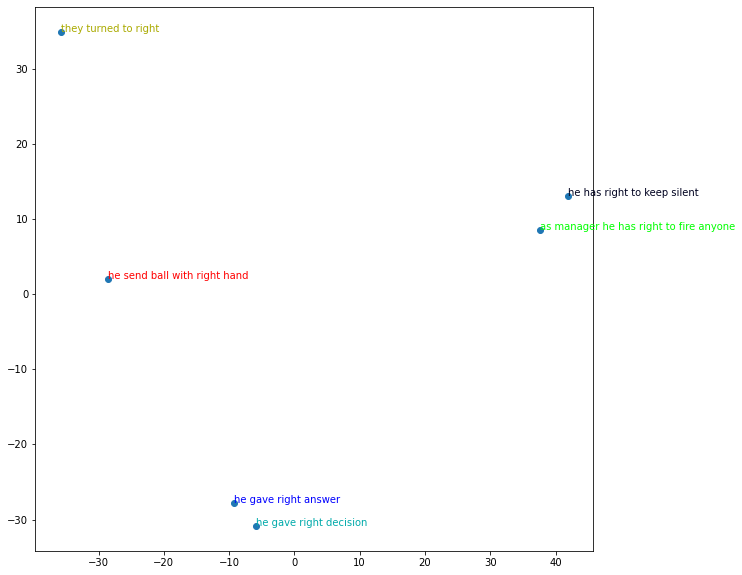

,he send ball with right hand,they turned to right,as manager he has right to fire anyone,he has right to keep silent,he gave right answer,he gave right decision
he send ball with right hand,1.000,0.764,-0.956,-0.931,0.245,0.118
they turned to right,0.764,1.000,-0.542,-0.476,-0.437,-0.550
as manager he has right to fire anyone,-0.956,-0.542,1.000,0.997,-0.518,-0.403
he has right to keep silent,-0.931,-0.476,0.997,1.000,-0.583,-0.473
he gave right answer,0.245,-0.437,-0.518,-0.583,1.000,0.992
he gave right decision,0.118,-0.550,-0.403,-0.473,0.992,1.000


In [12]:
right_sentences_short = [ 
"he send ball with right hand",       
"they turned to right",
"as manager he has right to fire anyone",
"he has right to keep silent",
"he gave right answer",
"he gave right decision"]
keywords = ["right"]

word_embeddings,_,x_reduced  = reduce_dim_draw( right_sentences_short,keywords ,tokenizer_nottrained,bert_model_nottrained)
df = draw_inner_cosine(x_reduced ,right_sentences_short)
display( df )

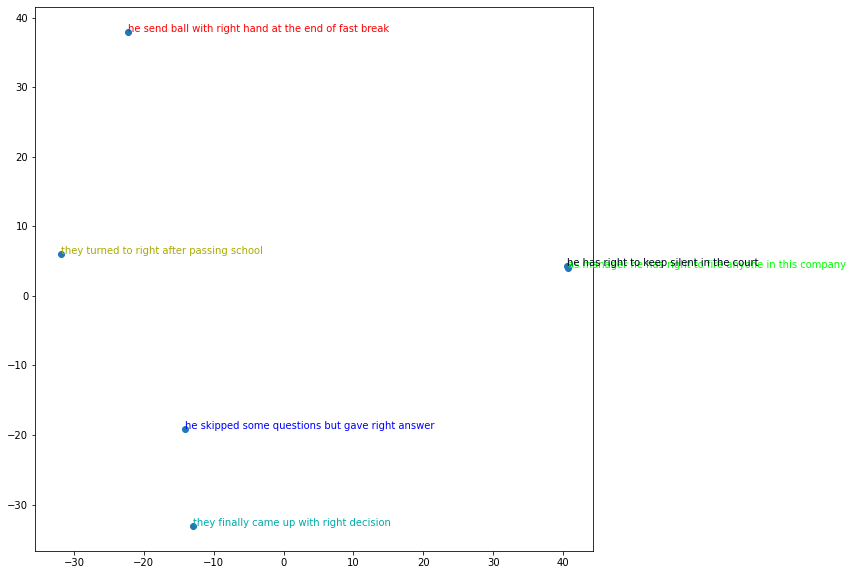

,he send ball with right hand at the end of fast break,they turned to right after passing school,as manager he has right to fire anyone in this company,he has right to keep silent in the court,he skipped some questions but gave right answer,they finally came up with right decision
he send ball with right hand at the end of fast break,1.000,0.657,-0.418,-0.413,-0.395,-0.619
they turned to right after passing school,0.657,1.000,-0.959,-0.958,0.433,0.186
as manager he has right to fire anyone in this company,-0.418,-0.959,1.000,1.000,-0.670,-0.455
he has right to keep silent in the court,-0.413,-0.958,1.000,1.000,-0.674,-0.460
he skipped some questions but gave right answer,-0.395,0.433,-0.670,-0.674,1.000,0.966
they finally came up with right decision,-0.619,0.186,-0.455,-0.460,0.966,1.000


In [13]:
right_sentences_medium = [ 
"he send ball with right hand at the end of fast break",       
"they turned to right after passing school",
"as manager he has right to fire anyone in this company",
"he has right to keep silent in the court",
"he skipped some questions but gave right answer",
"they finally came up with right decision"]
keywords = ["right"]

word_embeddings,_,x_reduced  = reduce_dim_draw( right_sentences_medium,keywords,tokenizer_nottrained,bert_model_nottrained)
df = draw_inner_cosine(x_reduced ,right_sentences_medium)
display( df )

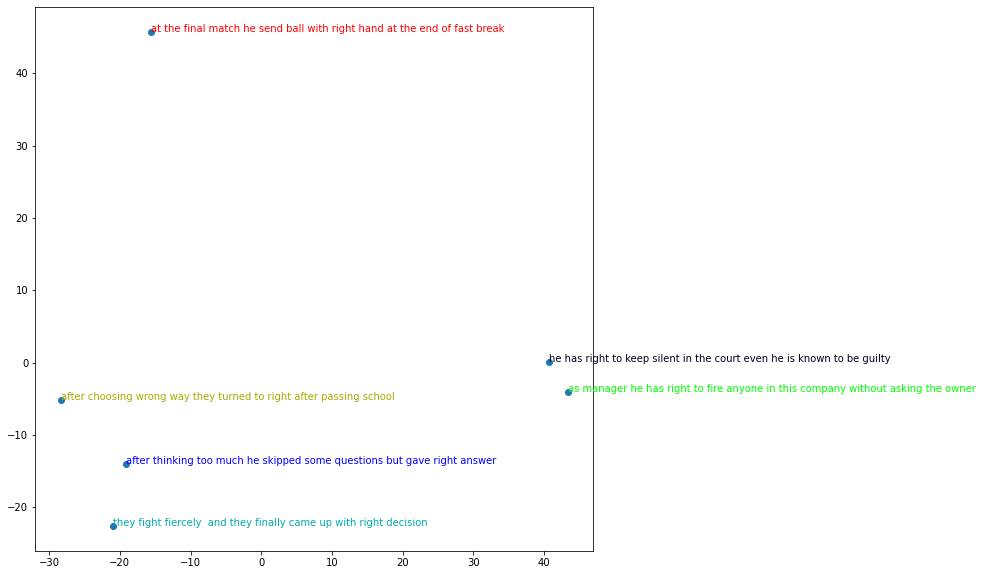

,at the final match he send ball with right hand at the end of fast break,after choosing wrong way they turned to right after passing school,as manager he has right to fire anyone in this company without asking the owner,he has right to keep silent in the court even he is known to be guilty,after thinking too much he skipped some questions but gave right answer,they fight fiercely and they finally came up with right decision
at the final match he send ball with right hand at the end of fast break,1.000,0.151,-0.409,-0.323,-0.299,-0.473
after choosing wrong way they turned to right after passing school,0.151,1.000,-0.964,-0.984,0.899,0.800
as manager he has right to fire anyone in this company without asking the owner,-0.409,-0.964,1.000,0.996,-0.749,-0.611
he has right to keep silent in the court even he is known to be guilty,-0.323,-0.984,0.996,1.000,-0.807,-0.681
after thinking too much he skipped some questions but gave right answer,-0.299,0.899,-0.749,-0.807,1.000,0.982
they fight fiercely and they finally came up with right decision,-0.473,0.800,-0.611,-0.681,0.982,1.000


In [14]:
right_sentences_long = [ 
"at the final match he send ball with right hand at the end of fast break",       
"after choosing wrong way they turned to right after passing school",
"as manager he has right to fire anyone in this company without asking the owner",
"he has right to keep silent in the court even he is known to be guilty",
"after thinking too much he skipped some questions but gave right answer",
"they fight fiercely  and they finally came up with right decision"]
keywords = ["right"]

word_embeddings,_,x_reduced  = reduce_dim_draw( right_sentences_long,keywords,tokenizer_nottrained,bert_model_nottrained)
df = draw_inner_cosine(x_reduced ,right_sentences_long)
display( df )

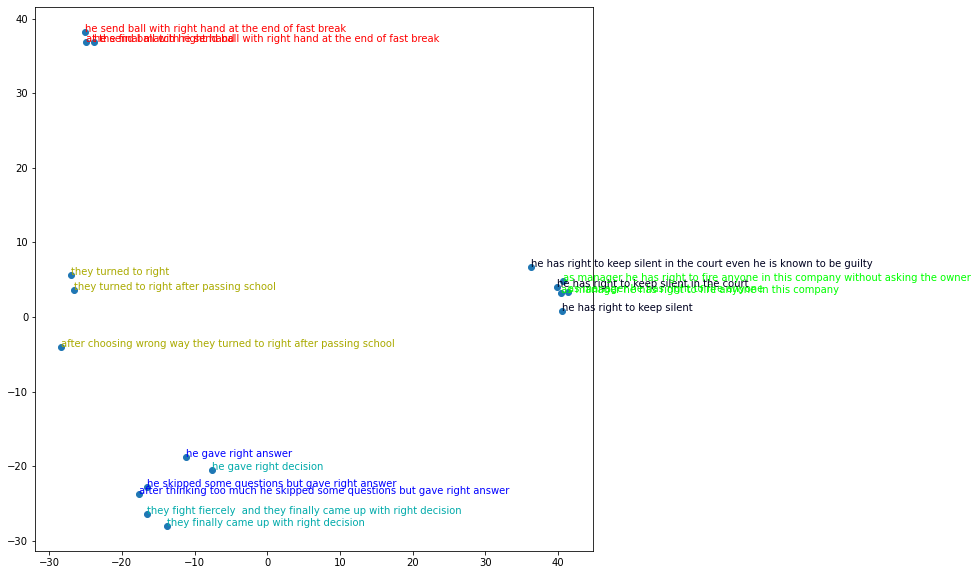

,he send ball with right hand,they turned to right,as manager he has right to fire anyone,he has right to keep silent,he gave right answer,he gave right decision,he send ball with right hand at the end of fast break,they turned to right after passing school,as manager he has right to fire anyone in this company,he has right to keep silent in the court,he skipped some questions but gave right answer,they finally came up with right decision,at the final match he send ball with right hand at the end of fast break,after choosing wrong way they turned to right after passing school,as manager he has right to fire anyone in this company without asking the owner,he has right to keep silent in the court even he is known to be guilty,after thinking too much he skipped some questions but gave right answer,they fight fiercely and they finally came up with right decision
he send ball with right hand,1.000,0.704,-0.473,-0.526,-0.441,-0.597,1.000,0.651,-0.475,-0.457,-0.361,-0.513,1.000,0.419,-0.441,-0.382,-0.349,-0.421
they turned to right,0.704,1.000,-0.959,-0.974,0.327,0.150,0.708,0.997,-0.959,-0.954,0.408,0.249,0.718,0.940,-0.948,-0.925,0.420,0.348
as manager he has right to fire anyone,-0.473,-0.959,1.000,0.998,-0.583,-0.425,-0.478,-0.977,1.000,1.000,-0.651,-0.514,-0.490,-0.998,0.999,0.995,-0.661,-0.600
he has right to keep silent,-0.526,-0.974,0.998,1.000,-0.531,-0.368,-0.531,-0.988,0.998,0.997,-0.603,-0.460,-0.543,-0.993,0.995,0.987,-0.613,-0.550
he gave right answer,-0.441,0.327,-0.583,-0.531,1.000,0.983,-0.436,0.394,-0.580,-0.597,0.996,0.997,-0.423,0.630,-0.611,-0.661,0.995,1.000
he gave right decision,-0.597,0.150,-0.425,-0.368,0.983,1.000,-0.592,0.220,-0.423,-0.441,0.964,0.995,-0.581,0.479,-0.457,-0.514,0.960,0.979
he send ball with right hand at the end of fast break,1.000,0.708,-0.478,-0.531,-0.436,-0.592,1.000,0.655,-0.480,-0.462,-0.356,-0.508,1.000,0.424,-0.446,-0.387,-0.344,-0.416
they turned to right after passing school,0.651,0.997,-0.977,-0.988,0.394,0.220,0.655,1.000,-0.977,-0.973,0.472,0.318,0.666,0.962,-0.968,-0.950,0.484,0.414
as manager he has right to fire anyone in this company,-0.475,-0.959,1.000,0.998,-0.580,-0.423,-0.480,-0.977,1.000,1.000,-0.649,-0.512,-0.492,-0.998,0.999,0.995,-0.659,-0.598
he has right to keep silent in the court,-0.457,-0.954,1.000,0.997,-0.597,-0.441,-0.462,-0.973,1.000,1.000,-0.664,-0.529,-0.475,-0.999,1.000,0.997,-0.674,-0.614


In [15]:
right_sentences = right_sentences_short + right_sentences_medium + right_sentences_long

keyword = ["right"]

word_embeddings,_,x_reduced = reduce_dim_draw( right_sentences,keyword,tokenizer_nottrained,bert_model_nottrained)

draw_inner_cosine(x_reduced,right_sentences)

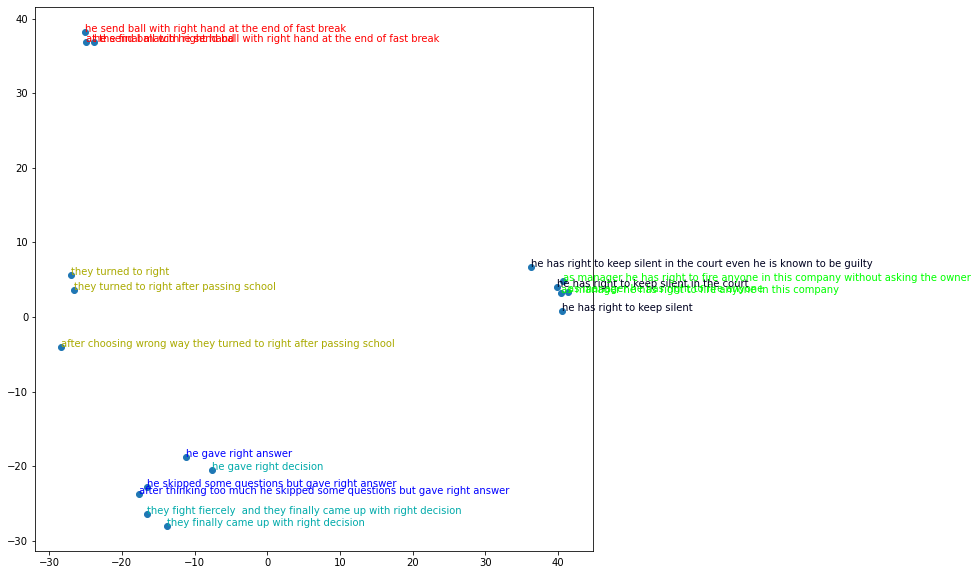

,he send ball with right hand,they turned to right,as manager he has right to fire anyone,he has right to keep silent,he gave right answer,he gave right decision,he send ball with right hand at the end of fast break,they turned to right after passing school,as manager he has right to fire anyone in this company,he has right to keep silent in the court,he skipped some questions but gave right answer,they finally came up with right decision,at the final match he send ball with right hand at the end of fast break,after choosing wrong way they turned to right after passing school,as manager he has right to fire anyone in this company without asking the owner,he has right to keep silent in the court even he is known to be guilty,after thinking too much he skipped some questions but gave right answer,they fight fiercely and they finally came up with right decision
he send ball with right hand,1.000,0.704,-0.473,-0.526,-0.441,-0.597,1.000,0.651,-0.475,-0.457,-0.361,-0.513,1.000,0.419,-0.441,-0.382,-0.349,-0.421
they turned to right,0.704,1.000,-0.959,-0.974,0.327,0.150,0.708,0.997,-0.959,-0.954,0.408,0.249,0.718,0.940,-0.948,-0.925,0.420,0.348
as manager he has right to fire anyone,-0.473,-0.959,1.000,0.998,-0.583,-0.425,-0.478,-0.977,1.000,1.000,-0.651,-0.514,-0.490,-0.998,0.999,0.995,-0.661,-0.600
he has right to keep silent,-0.526,-0.974,0.998,1.000,-0.531,-0.368,-0.531,-0.988,0.998,0.997,-0.603,-0.460,-0.543,-0.993,0.995,0.987,-0.613,-0.550
he gave right answer,-0.441,0.327,-0.583,-0.531,1.000,0.983,-0.436,0.394,-0.580,-0.597,0.996,0.997,-0.423,0.630,-0.611,-0.661,0.995,1.000
he gave right decision,-0.597,0.150,-0.425,-0.368,0.983,1.000,-0.592,0.220,-0.423,-0.441,0.964,0.995,-0.581,0.479,-0.457,-0.514,0.960,0.979
he send ball with right hand at the end of fast break,1.000,0.708,-0.478,-0.531,-0.436,-0.592,1.000,0.655,-0.480,-0.462,-0.356,-0.508,1.000,0.424,-0.446,-0.387,-0.344,-0.416
they turned to right after passing school,0.651,0.997,-0.977,-0.988,0.394,0.220,0.655,1.000,-0.977,-0.973,0.472,0.318,0.666,0.962,-0.968,-0.950,0.484,0.414
as manager he has right to fire anyone in this company,-0.475,-0.959,1.000,0.998,-0.580,-0.423,-0.480,-0.977,1.000,1.000,-0.649,-0.512,-0.492,-0.998,0.999,0.995,-0.659,-0.598
he has right to keep silent in the court,-0.457,-0.954,1.000,0.997,-0.597,-0.441,-0.462,-0.973,1.000,1.000,-0.664,-0.529,-0.475,-0.999,1.000,0.997,-0.674,-0.614


In [16]:
#also combine all sentences and check how does it look like when plotted together
right_sentences = right_sentences_short + right_sentences_medium + right_sentences_long

keyword = ["right"]

word_embeddings,_,x_reduced = reduce_dim_draw( right_sentences,keyword ,tokenizer_nottrained,bert_model_nottrained)

draw_inner_cosine(x_reduced,right_sentences)


In [17]:
sentences = [ 
    "the shop is at right",   
"they turned to right",
"he was walking in streets realized a shop at right",   
"they passed street school was at right",
"he was walking in streets and having leisure by checking shops he realized a shop at right",   
"when he checks map he realized he will drive for 1 hour and stop at right of market",
"they passed the street they were not sure what they were doing the school was at right",
"the lion suddenly began to run to right for catching deer",
"turn left walk straight then turn right you will see school",
"he was using his right arm for daily works left arm for tennis",
"i have the right to enter library",
"he still have the right to enter library",
"as i valid passport holder i have the right to enter",
"i think even if he leaves school he must still have the right to enter library",
"as i valid passport holder i have the right to enter that country as much as i want",
"even they are divorced he has the right to see his children",
"human right is the difference between developed and undeveloped countries",
"You're right to be annoyed for bad behavior",
"She campaigned for women's right in her country",
"Everyone has a right to get education",
"for difficult question he gave right answer",
"for complicated problems he gave right decision",
"he skipped some questions but gave right answer",
"they finally came up with right decision",
"he skipped some questions he was so excited at the interview but at the end he gave right answer",
"after lots of discussion everyone believed they finally came up with right decision",
"this is not the right attitude for talking with children when they make a mistake",
"every problem is unique so right approach depends on complexity of problem",
"although he deserved to be fired this was the right way to do so",
"he is not the right person to ask this question"
]

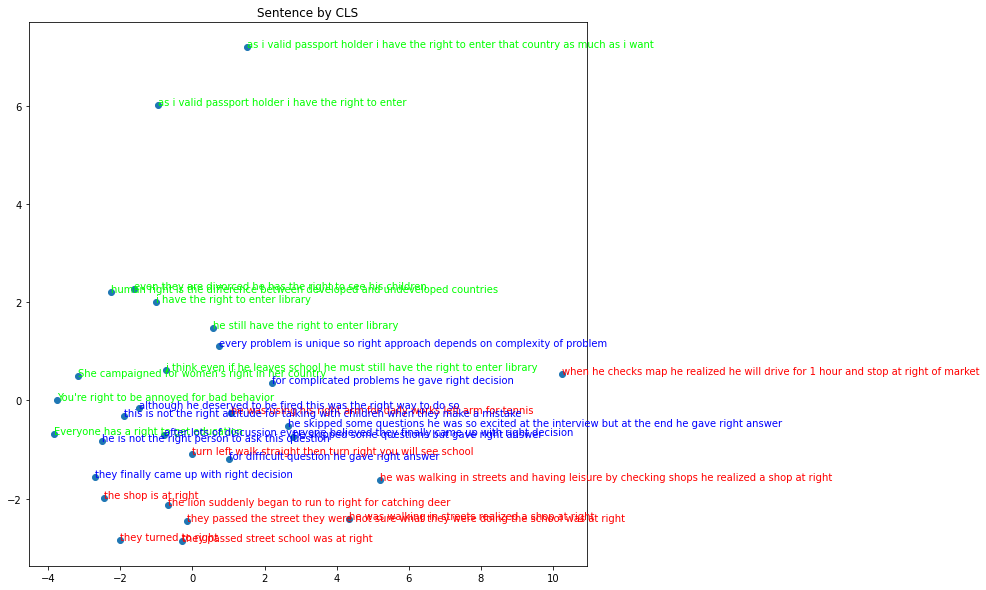

In [82]:
outputs = [ get_bert_output_cls(tokenizer_nottrained,bert_model_nottrained,s).detach().numpy() for s in sentences]
_ = dump_on_surface(outputs,sentences,fitting="pca",dump_3d=False,dump_2d=True,color_by="index10",
                    title="Sentence by CLS")

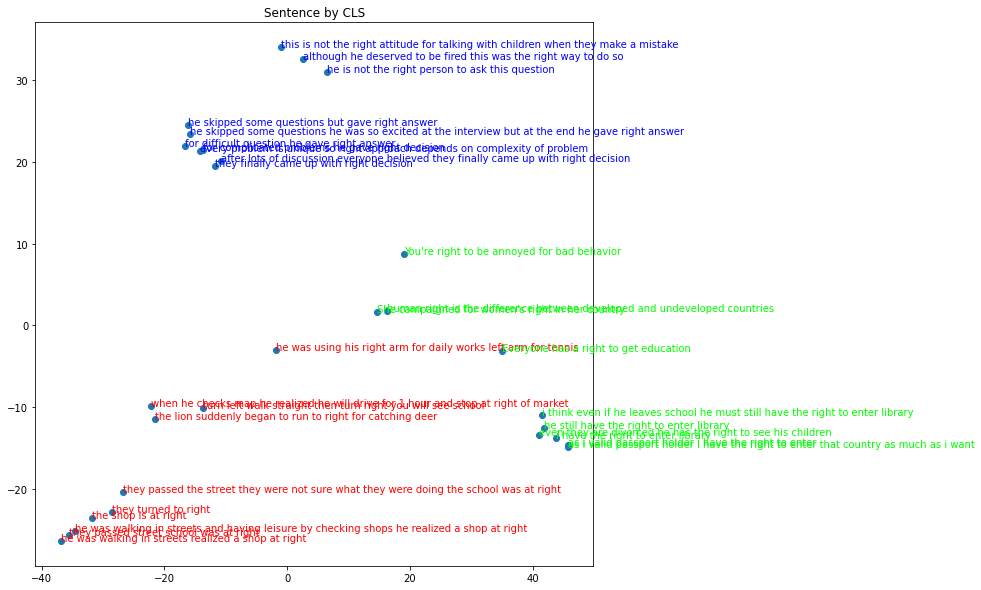

In [18]:
outputs = [ get_word_embeddings(tokenizer_nottrained,bert_model_nottrained,s,"right")[0].vector.detach().numpy() for s in sentences]
_ = dump_on_surface(outputs,sentences,fitting="pca",dump_3d=False,dump_2d=True,color_by="index10",
                    title="Sentence by CLS")

In [19]:
#utility methods for creating dataframe
def get_df():
    df = pd.DataFrame()
    df["Sentence"] = sentences
    df["Group"] = [ (index // 10) for index,s in enumerate(sentences) ]
    return df

In [20]:
input_df = None
CLASS_NUMS = None

#Uncomment related block to see different architectures and results.
input_df = get_df()
CLASS_NUMS = 3



input_df.head(30)

,Sentence,Group
0,the shop is at right,0
1,they turned to right,0
2,he was walking in streets realized a shop at r...,0
3,they passed street school was at right,0
4,he was walking in streets and having leisure b...,0
5,when he checks map he realized he will drive f...,0
6,they passed the street they were not sure what...,0
7,the lion suddenly began to run to right for ca...,0
8,turn left walk straight then turn right you wi...,0
9,he was using his right arm for daily works lef...,0


In [23]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased', truncation=True, do_lower_case=True)

In [24]:
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler

class SentimentData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len):
        self.tokenizer = tokenizer
        self.data = dataframe
        self.text = dataframe["Sentence"]
        self.targets = dataframe["Group"]
        self.max_len = max_len

    def __len__(self):
        return len(self.text)

    def __getitem__(self, index):
        text = str(self.text[index])
        target = self.targets[index]

        return text,target

In [25]:
training_set = SentimentData(input_df, tokenizer, MAX_LEN)
#My dataset is small, I am doing only for visualizing so I dont use test set
train_params = {'batch_size': 4,'shuffle': True}
training_loader = DataLoader(training_set, **train_params)

In [45]:
class BertClassifier(torch.nn.Module):
    def __init__(self,nn_tokenizer,nn_bert_model,is_sentence):
        super(BertClassifier, self).__init__()
        #TODO
        #nn_bert_model.train()
        #nn_bert_model.eval()
        self.nn_bert_model = nn_bert_model 
        self.nn_tokenizer = nn_tokenizer
        self.is_sentence = is_sentence
        self.classifier = torch.nn.Linear(768, CLASS_NUMS)

    def forward(self, sentence_list):
        
        #TODO
        embeddings = None
        if self.is_sentence :
            embeddings = [get_bert_output_cls(self.nn_tokenizer,self.nn_bert_model,s) for s in sentence_list ]
        else:
            embeddings = [get_word_embeddings(self.nn_tokenizer,self.nn_bert_model,s,"right")[0].vector for s in sentence_list ]
        
        bert_vector = torch.stack(embeddings)
                
        relu_output = torch.nn.ReLU()(bert_vector)                
        output = self.classifier(relu_output)
        return output

In [46]:
def freeze_model(bert_model_):
    for param in bert_model_.base_model.parameters():
        param.requires_grad = False
    

In [47]:
#train Classfier network
def train(epoch,classfier_):

    correct_predictions = 0
    classfier_.train()
    for _,data in tqdm(enumerate(training_loader, 0)):
        #get data and labels
        sentence_batch = data[0]
        targets = data[1].to(device, dtype = torch.long)
        #call network forward and calculate loss
        outputs = classfier_(sentence_batch)
        loss = loss_function(outputs, targets)
        #get predictions and compare with actual        
        _, predicted_groups = torch.max(outputs.data, dim=1)        
        correct_predictions += (predicted_groups  == targets).sum().item()
            
        #do back propagation    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    epoch_accu = int( ( correct_predictions * 100 )/len(sentences) )        

    return epoch_accu

In [56]:
bert_model_freezed_sentence = BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True )
classfier_freezed_sentence = BertClassifier(tokenizer,bert_model_freezed_sentence,is_sentence=True)
bert_model_freezed_sentence.eval()
freeze_model( bert_model_freezed_sentence )
_ = classfier_freezed_sentence.to(device)

In [63]:
bert_model_freezed_word = BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True )
classfier_freezed_word = BertClassifier(tokenizer,bert_model_freezed_word,is_sentence=False)

bert_model_freezed_word.eval()
freeze_model( bert_model_freezed_word )
_ = classfier_freezed_word.to(device)

In [58]:
bert_model_trained_sentence = BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True )
classfier_trained_sentence = BertClassifier(tokenizer,bert_model_trained_sentence,is_sentence=True)
bert_model_trained_sentence.train()
_ = classfier_trained_sentence.to(device)

In [59]:
bert_model_trained_word = BertModel.from_pretrained('bert-base-uncased',output_hidden_states = True )
classfier_trained_word = BertClassifier(tokenizer,bert_model_trained_word,is_sentence=False)
bert_model_trained_word.train()
_ = classfier_trained_word.to(device)

In [60]:
pytorch_total_params = sum(p.numel() for p in classfier_freezed.parameters() if p.requires_grad)    
pytorch_trainable_params = sum(p.numel() for p in classfier_freezed.parameters() )    
print("Total number of params", pytorch_total_params)
print("Total number of trainable params", pytorch_trainable_params)
#Near 110 million parameter only for Bert 109482240
#Our model + Bert has = 109484547
# 109484547
# 109482240
# ---------
#      2307
#so the layers we added has only 2307 layers

Total number of params 2307
Total number of trainable params 109484547


In [61]:
pytorch_total_params = sum(p.numel() for p in classfier_trained.parameters() if p.requires_grad)    
pytorch_trainable_params = sum(p.numel() for p in classfier_trained.parameters() )    
print("Total number of params", pytorch_total_params)
print("Total number of trainable params", pytorch_trainable_params)

Total number of params 109484547
Total number of trainable params 109484547


In [54]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  classfier_freezed_sentence.parameters(), lr=1e-05)


EPOCHS = 30
for epoch in range(EPOCHS):
    epoch_accu = train(epoch,classfier_freezed_sentence)
    print(f"At Epoch {epoch+1}  Accuracy : {epoch_accu}" )
    if epoch_accu > 97:
        break

8it [00:02,  3.09it/s]
0it [00:00, ?it/s]

At Epoch 1  Accuracy : 26


8it [00:02,  3.10it/s]
0it [00:00, ?it/s]

At Epoch 2  Accuracy : 30


8it [00:02,  3.02it/s]
0it [00:00, ?it/s]

At Epoch 3  Accuracy : 30


8it [00:02,  2.87it/s]
0it [00:00, ?it/s]

At Epoch 4  Accuracy : 33


8it [00:02,  3.08it/s]
0it [00:00, ?it/s]

At Epoch 5  Accuracy : 43


8it [00:02,  3.01it/s]
0it [00:00, ?it/s]

At Epoch 6  Accuracy : 36


8it [00:02,  3.04it/s]
0it [00:00, ?it/s]

At Epoch 7  Accuracy : 33


8it [00:02,  3.06it/s]
0it [00:00, ?it/s]

At Epoch 8  Accuracy : 33


8it [00:02,  3.01it/s]
0it [00:00, ?it/s]

At Epoch 9  Accuracy : 46


8it [00:02,  2.74it/s]
0it [00:00, ?it/s]

At Epoch 10  Accuracy : 36


8it [00:02,  3.00it/s]
0it [00:00, ?it/s]

At Epoch 11  Accuracy : 36


8it [00:02,  3.06it/s]
0it [00:00, ?it/s]

At Epoch 12  Accuracy : 23


8it [00:02,  2.79it/s]
0it [00:00, ?it/s]

At Epoch 13  Accuracy : 33


8it [00:02,  2.96it/s]
0it [00:00, ?it/s]

At Epoch 14  Accuracy : 30


8it [00:02,  2.72it/s]
0it [00:00, ?it/s]

At Epoch 15  Accuracy : 40


8it [00:02,  2.87it/s]
0it [00:00, ?it/s]

At Epoch 16  Accuracy : 30


8it [00:02,  3.09it/s]
0it [00:00, ?it/s]

At Epoch 17  Accuracy : 46


8it [00:02,  2.89it/s]
0it [00:00, ?it/s]

At Epoch 18  Accuracy : 30


8it [00:02,  2.93it/s]
0it [00:00, ?it/s]

At Epoch 19  Accuracy : 40


8it [00:02,  2.99it/s]
0it [00:00, ?it/s]

At Epoch 20  Accuracy : 40


8it [00:02,  2.73it/s]
0it [00:00, ?it/s]

At Epoch 21  Accuracy : 46


8it [00:02,  2.93it/s]
0it [00:00, ?it/s]

At Epoch 22  Accuracy : 43


8it [00:02,  2.92it/s]
0it [00:00, ?it/s]

At Epoch 23  Accuracy : 46


8it [00:02,  3.08it/s]
0it [00:00, ?it/s]

At Epoch 24  Accuracy : 36


8it [00:02,  2.89it/s]
0it [00:00, ?it/s]

At Epoch 25  Accuracy : 43


8it [00:02,  3.07it/s]
0it [00:00, ?it/s]

At Epoch 26  Accuracy : 33


8it [00:02,  2.70it/s]
0it [00:00, ?it/s]

At Epoch 27  Accuracy : 33


8it [00:02,  3.14it/s]
0it [00:00, ?it/s]

At Epoch 28  Accuracy : 50


8it [00:02,  3.09it/s]
0it [00:00, ?it/s]

At Epoch 29  Accuracy : 40


8it [00:02,  3.02it/s]

At Epoch 30  Accuracy : 46


In [64]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  classfier_freezed_word.parameters(), lr=1e-05)


EPOCHS = 30
for epoch in range(EPOCHS):
    epoch_accu = train(epoch,classfier_freezed_word)
    print(f"At Epoch {epoch+1}  Accuracy : {epoch_accu}" )
    if epoch_accu > 97:
        break

8it [00:02,  3.10it/s]
0it [00:00, ?it/s]

At Epoch 1  Accuracy : 33


8it [00:02,  2.84it/s]
0it [00:00, ?it/s]

At Epoch 2  Accuracy : 33


8it [00:02,  2.78it/s]
0it [00:00, ?it/s]

At Epoch 3  Accuracy : 33


8it [00:03,  2.36it/s]
0it [00:00, ?it/s]

At Epoch 4  Accuracy : 30


8it [00:02,  3.06it/s]
0it [00:00, ?it/s]

At Epoch 5  Accuracy : 30


8it [00:02,  3.32it/s]
0it [00:00, ?it/s]

At Epoch 6  Accuracy : 26


8it [00:02,  3.01it/s]
0it [00:00, ?it/s]

At Epoch 7  Accuracy : 26


8it [00:02,  2.99it/s]
0it [00:00, ?it/s]

At Epoch 8  Accuracy : 33


8it [00:02,  2.93it/s]
0it [00:00, ?it/s]

At Epoch 9  Accuracy : 30


8it [00:03,  2.23it/s]
0it [00:00, ?it/s]

At Epoch 10  Accuracy : 33


8it [00:02,  2.93it/s]
0it [00:00, ?it/s]

At Epoch 11  Accuracy : 23


8it [00:02,  2.96it/s]
0it [00:00, ?it/s]

At Epoch 12  Accuracy : 26


8it [00:02,  2.76it/s]
0it [00:00, ?it/s]

At Epoch 13  Accuracy : 36


8it [00:03,  2.29it/s]
0it [00:00, ?it/s]

At Epoch 14  Accuracy : 30


8it [00:03,  2.39it/s]
0it [00:00, ?it/s]

At Epoch 15  Accuracy : 30


8it [00:02,  2.86it/s]
0it [00:00, ?it/s]

At Epoch 16  Accuracy : 26


8it [00:02,  3.03it/s]
0it [00:00, ?it/s]

At Epoch 17  Accuracy : 36


8it [00:02,  2.89it/s]
0it [00:00, ?it/s]

At Epoch 18  Accuracy : 30


8it [00:02,  3.02it/s]
0it [00:00, ?it/s]

At Epoch 19  Accuracy : 33


8it [00:02,  3.15it/s]
0it [00:00, ?it/s]

At Epoch 20  Accuracy : 33


8it [00:02,  3.11it/s]
0it [00:00, ?it/s]

At Epoch 21  Accuracy : 26


8it [00:02,  3.19it/s]
0it [00:00, ?it/s]

At Epoch 22  Accuracy : 36


8it [00:02,  3.17it/s]
0it [00:00, ?it/s]

At Epoch 23  Accuracy : 23


8it [00:02,  3.23it/s]
0it [00:00, ?it/s]

At Epoch 24  Accuracy : 46


8it [00:02,  2.96it/s]
0it [00:00, ?it/s]

At Epoch 25  Accuracy : 26


8it [00:02,  3.15it/s]
0it [00:00, ?it/s]

At Epoch 26  Accuracy : 36


8it [00:02,  3.21it/s]
0it [00:00, ?it/s]

At Epoch 27  Accuracy : 36


8it [00:02,  2.92it/s]
0it [00:00, ?it/s]

At Epoch 28  Accuracy : 33


8it [00:02,  3.08it/s]
0it [00:00, ?it/s]

At Epoch 29  Accuracy : 43


8it [00:02,  3.06it/s]

At Epoch 30  Accuracy : 30


In [65]:
# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  classfier_trained_sentence.parameters(), lr=1e-05)


EPOCHS = 30
for epoch in range(EPOCHS):
    epoch_accu = train(epoch,classfier_trained_sentence)
    print(f"At Epoch {epoch+1}  Accuracy : {epoch_accu}")
    if epoch_accu > 97:
        break

8it [00:23,  2.93s/it]
0it [00:00, ?it/s]

At Epoch 1  Accuracy : 43


8it [00:23,  2.97s/it]
0it [00:00, ?it/s]

At Epoch 2  Accuracy : 83


8it [00:23,  2.88s/it]
0it [00:00, ?it/s]

At Epoch 3  Accuracy : 96


8it [00:22,  2.85s/it]

At Epoch 4  Accuracy : 100


In [66]:

# Creating the loss function and optimizer
loss_function = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params =  classfier_trained_word.parameters(), lr=1e-05)


EPOCHS = 30
for epoch in range(EPOCHS):
    epoch_accu = train(epoch,classfier_trained_word)
    print(f"At Epoch {epoch+1}  Accuracy : {epoch_accu}")
    if epoch_accu > 97:
        break

8it [00:02,  3.21it/s]
0it [00:00, ?it/s]

At Epoch 1  Accuracy : 43


8it [00:02,  2.88it/s]
0it [00:00, ?it/s]

At Epoch 2  Accuracy : 23


8it [00:02,  3.46it/s]
0it [00:00, ?it/s]

At Epoch 3  Accuracy : 26


8it [00:02,  3.35it/s]
0it [00:00, ?it/s]

At Epoch 4  Accuracy : 36


8it [00:02,  3.52it/s]
0it [00:00, ?it/s]

At Epoch 5  Accuracy : 40


8it [00:02,  3.43it/s]
0it [00:00, ?it/s]

At Epoch 6  Accuracy : 43


8it [00:02,  3.45it/s]
0it [00:00, ?it/s]

At Epoch 7  Accuracy : 33


8it [00:02,  3.32it/s]
0it [00:00, ?it/s]

At Epoch 8  Accuracy : 36


8it [00:02,  3.03it/s]
0it [00:00, ?it/s]

At Epoch 9  Accuracy : 50


8it [00:02,  3.49it/s]
0it [00:00, ?it/s]

At Epoch 10  Accuracy : 36


8it [00:02,  3.52it/s]
0it [00:00, ?it/s]

At Epoch 11  Accuracy : 26


8it [00:02,  3.58it/s]
0it [00:00, ?it/s]

At Epoch 12  Accuracy : 36


8it [00:02,  2.90it/s]
0it [00:00, ?it/s]

At Epoch 13  Accuracy : 43


8it [00:03,  2.64it/s]
0it [00:00, ?it/s]

At Epoch 14  Accuracy : 36


8it [00:02,  2.68it/s]
0it [00:00, ?it/s]

At Epoch 15  Accuracy : 46


8it [00:02,  3.49it/s]
0it [00:00, ?it/s]

At Epoch 16  Accuracy : 40


8it [00:02,  3.59it/s]
0it [00:00, ?it/s]

At Epoch 17  Accuracy : 43


8it [00:02,  3.54it/s]
0it [00:00, ?it/s]

At Epoch 18  Accuracy : 46


8it [00:02,  3.44it/s]
0it [00:00, ?it/s]

At Epoch 19  Accuracy : 50


8it [00:02,  3.26it/s]
0it [00:00, ?it/s]

At Epoch 20  Accuracy : 46


8it [00:02,  2.90it/s]
0it [00:00, ?it/s]

At Epoch 21  Accuracy : 43


8it [00:03,  2.65it/s]
0it [00:00, ?it/s]

At Epoch 22  Accuracy : 50


8it [00:03,  2.22it/s]
0it [00:00, ?it/s]

At Epoch 23  Accuracy : 53


8it [00:02,  3.40it/s]
0it [00:00, ?it/s]

At Epoch 24  Accuracy : 53


8it [00:02,  3.43it/s]
0it [00:00, ?it/s]

At Epoch 25  Accuracy : 50


8it [00:02,  2.99it/s]
0it [00:00, ?it/s]

At Epoch 26  Accuracy : 56


8it [00:02,  2.90it/s]
0it [00:00, ?it/s]

At Epoch 27  Accuracy : 53


8it [00:02,  3.41it/s]
0it [00:00, ?it/s]

At Epoch 28  Accuracy : 60


8it [00:02,  3.10it/s]
0it [00:00, ?it/s]

At Epoch 29  Accuracy : 46


8it [00:02,  3.39it/s]

At Epoch 30  Accuracy : 56


In [67]:
#put Bert trained model into eval mode
_ = bert_model_trained_sentence.eval()
_ = bert_model_trained_word.eval()

_ = bert_model_freezed_sentence.eval()
_ = bert_model_freezed_word.eval()

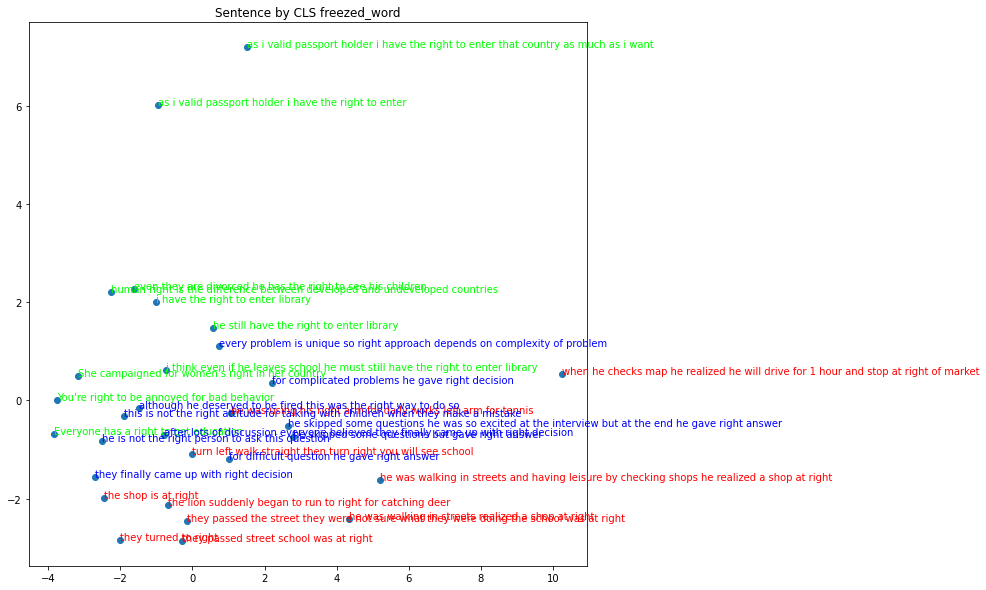

In [83]:
outputs = [ get_bert_output_cls(tokenizer,bert_model_freezed_word,s).numpy() for s in sentences]
_ = dump_on_surface(outputs,sentences,fitting="pca",dump_3d=False,dump_2d=True,color_by="index10",
                    title="Sentence by CLS freezed_word")

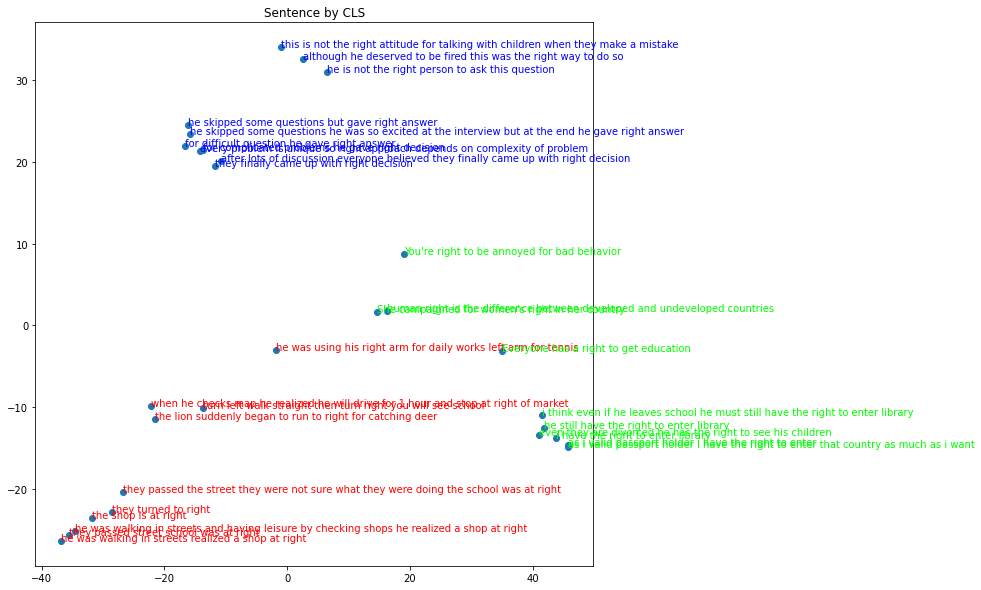

In [68]:
outputs = [ get_word_embeddings(tokenizer,bert_model_freezed_word,s,"right")[0].vector.detach().numpy() for s in sentences]
_ = dump_on_surface(outputs,sentences,fitting="pca",dump_3d=False,dump_2d=True,color_by="index10",
                    title="Sentence by CLS freezed_word")

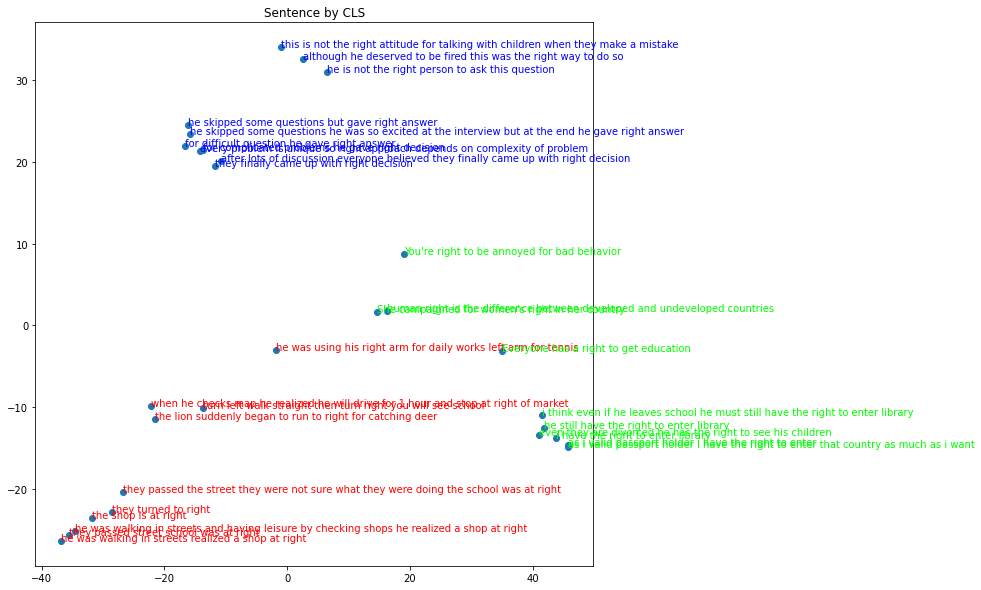

In [69]:
outputs = [ get_word_embeddings(tokenizer,bert_model_freezed_sentence,s,"right")[0].vector.detach().numpy() for s in sentences]
_ = dump_on_surface(outputs,sentences,fitting="pca",dump_3d=False,dump_2d=True,color_by="index10",
                    title="Sentence by CLS freezed_sentence")

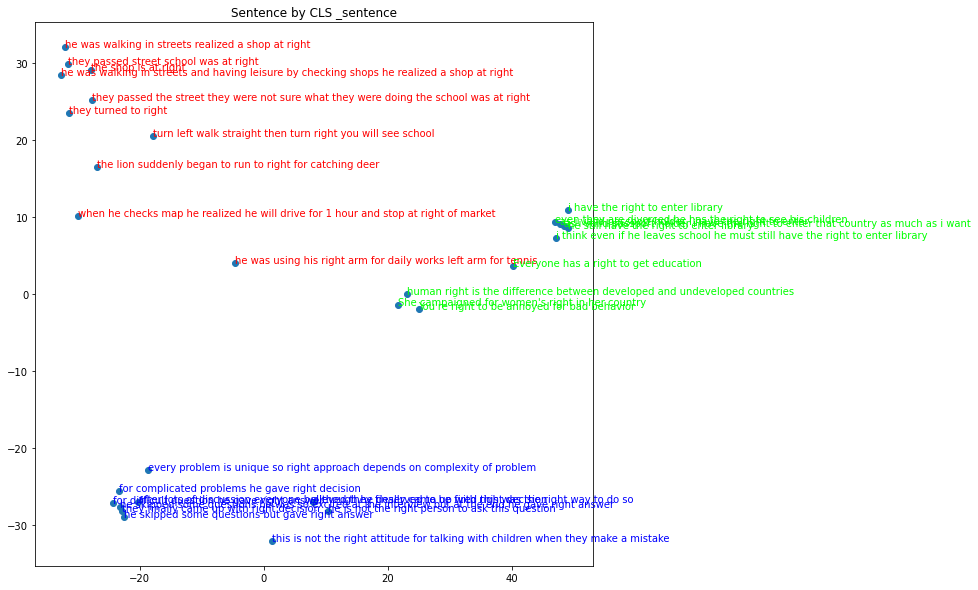

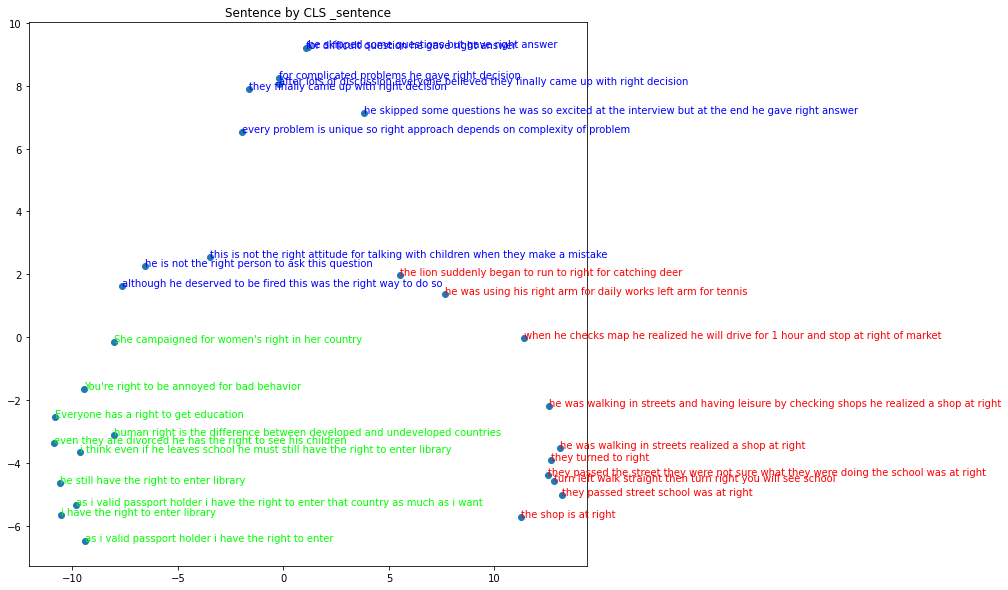

In [86]:
outputs = [ get_word_embeddings(tokenizer,bert_model_trained_sentence,s,"right")[0].vector.detach().numpy() for s in sentences]
_ = dump_on_surface(outputs,sentences,fitting="pca",dump_3d=False,dump_2d=True,color_by="index10",
                    title="Sentence by CLS _sentence")

outputs = [ get_bert_output_cls(tokenizer,bert_model_trained_sentence,s).detach().numpy() for s in sentences]
_ = dump_on_surface(outputs,sentences,fitting="pca",dump_3d=False,dump_2d=True,color_by="index10",
                    title="Sentence by CLS _sentence")

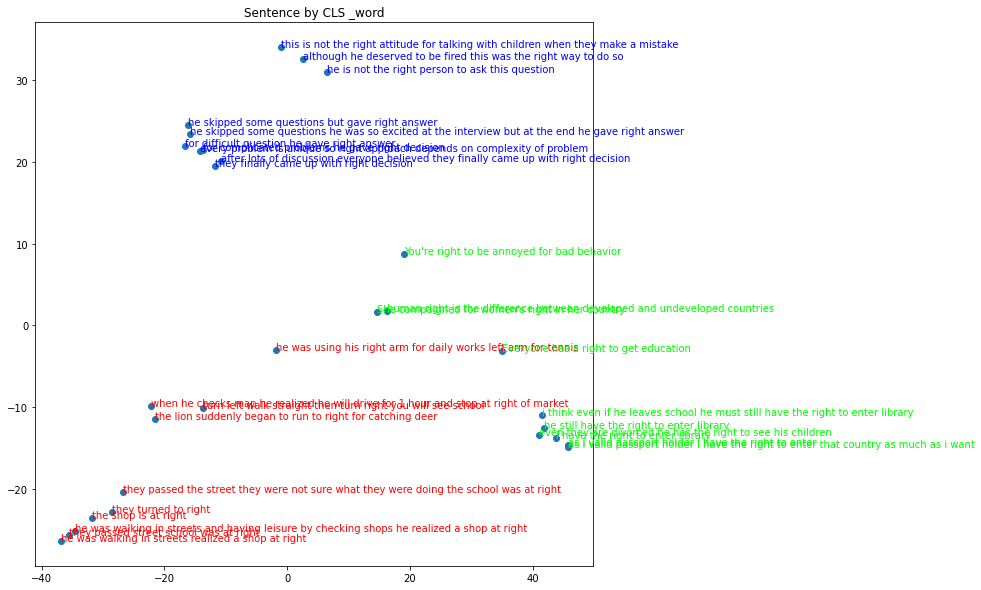

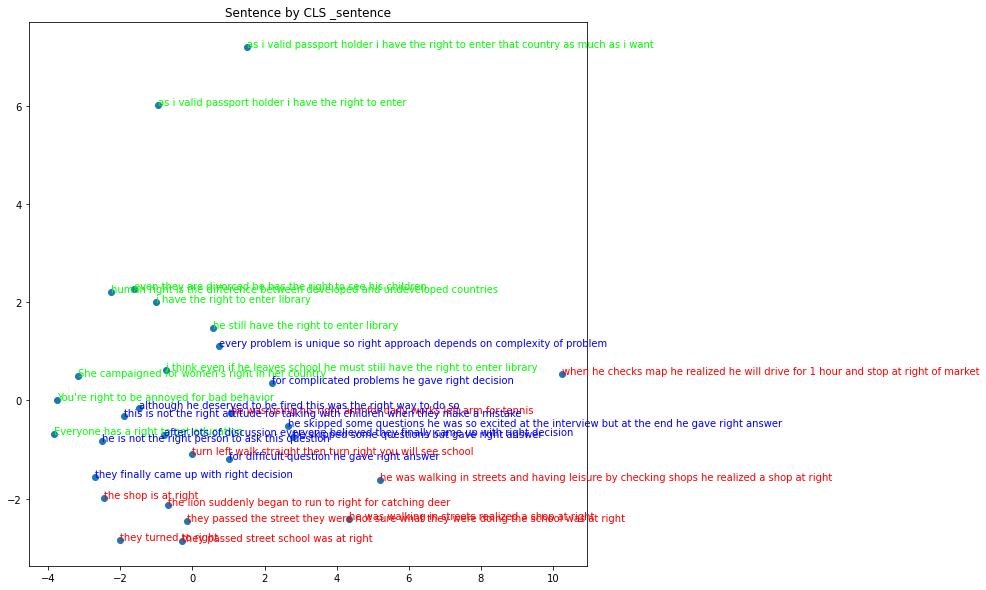

In [87]:
outputs = [ get_word_embeddings(tokenizer,bert_model_trained_word,s,"right")[0].vector.detach().numpy() for s in sentences]
_ = dump_on_surface(outputs,sentences,fitting="pca",dump_3d=False,dump_2d=True,color_by="index10",
                    title="Word by  _word")

outputs = [ get_bert_output_cls(tokenizer,bert_model_trained_word,s).detach().numpy() for s in sentences]
_ = dump_on_surface(outputs,sentences,fitting="pca",dump_3d=False,dump_2d=True,color_by="index10",
                    title="Sentence by CLS _word")

#Bert trained by word, did not seperate the Sentences at the end.

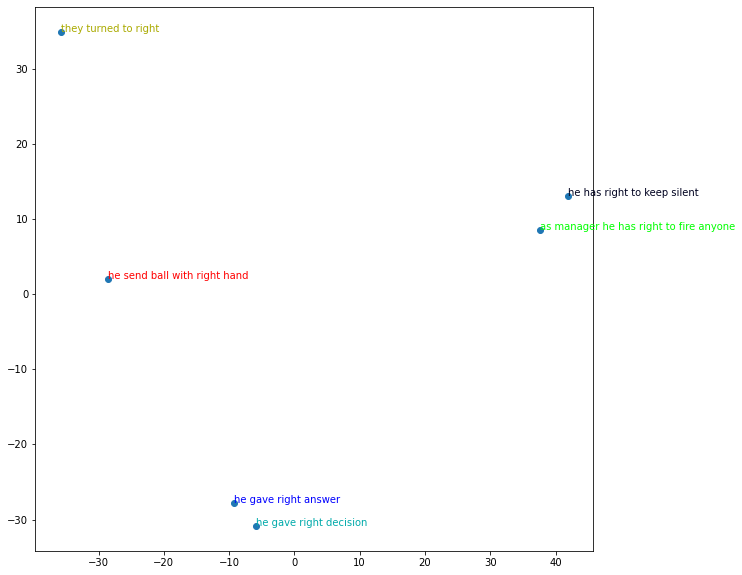

,he send ball with right hand,they turned to right,as manager he has right to fire anyone,he has right to keep silent,he gave right answer,he gave right decision
he send ball with right hand,1.000,0.765,-0.956,-0.931,0.245,0.118
they turned to right,0.765,1.000,-0.542,-0.476,-0.437,-0.550
as manager he has right to fire anyone,-0.956,-0.542,1.000,0.997,-0.518,-0.403
he has right to keep silent,-0.931,-0.476,0.997,1.000,-0.583,-0.473
he gave right answer,0.245,-0.437,-0.518,-0.583,1.000,0.992
he gave right decision,0.118,-0.550,-0.403,-0.473,0.992,1.000


In [142]:

keywords = ["right"]

word_embeddings,_,x_reduced  = reduce_dim_draw( right_sentences_short,keywords ,tokenizer,bert_model)
df = draw_inner_cosine(x_reduced ,right_sentences_short)
display( df )

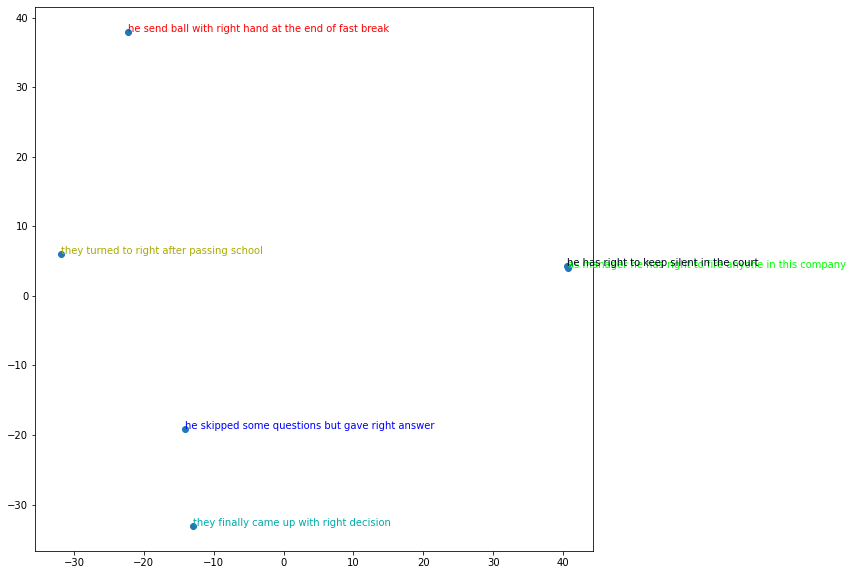

,he send ball with right hand at the end of fast break,they turned to right after passing school,as manager he has right to fire anyone in this company,he has right to keep silent in the court,he skipped some questions but gave right answer,they finally came up with right decision
he send ball with right hand at the end of fast break,1.000,0.657,-0.418,-0.413,-0.395,-0.619
they turned to right after passing school,0.657,1.000,-0.959,-0.958,0.433,0.186
as manager he has right to fire anyone in this company,-0.418,-0.959,1.000,1.000,-0.670,-0.455
he has right to keep silent in the court,-0.413,-0.958,1.000,1.000,-0.674,-0.460
he skipped some questions but gave right answer,-0.395,0.433,-0.670,-0.674,1.000,0.966
they finally came up with right decision,-0.619,0.186,-0.455,-0.460,0.966,1.000


In [33]:

keywords = ["right"]

word_embeddings,_,x_reduced  = reduce_dim_draw( right_sentences_medium,keywords ,tokenizer,bert_model)
df = draw_inner_cosine(x_reduced ,right_sentences_medium)
display( df )

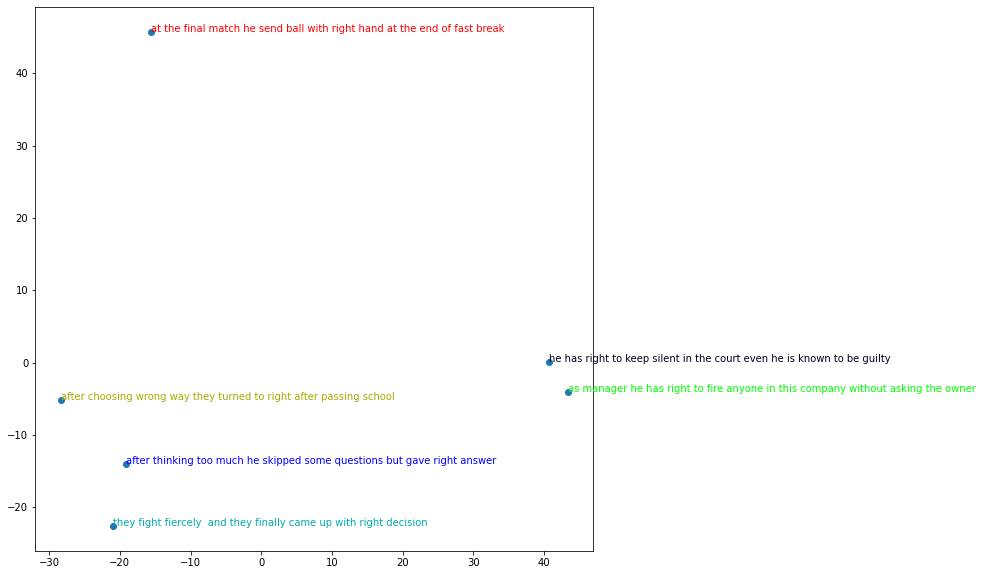

,at the final match he send ball with right hand at the end of fast break,after choosing wrong way they turned to right after passing school,as manager he has right to fire anyone in this company without asking the owner,he has right to keep silent in the court even he is known to be guilty,after thinking too much he skipped some questions but gave right answer,they fight fiercely and they finally came up with right decision
at the final match he send ball with right hand at the end of fast break,1.000,0.151,-0.409,-0.323,-0.299,-0.473
after choosing wrong way they turned to right after passing school,0.151,1.000,-0.964,-0.984,0.899,0.800
as manager he has right to fire anyone in this company without asking the owner,-0.409,-0.964,1.000,0.996,-0.749,-0.611
he has right to keep silent in the court even he is known to be guilty,-0.323,-0.984,0.996,1.000,-0.807,-0.681
after thinking too much he skipped some questions but gave right answer,-0.299,0.899,-0.749,-0.807,1.000,0.982
they fight fiercely and they finally came up with right decision,-0.473,0.800,-0.611,-0.681,0.982,1.000


In [34]:


keywords = ["right"]

word_embeddings,_,x_reduced  = reduce_dim_draw( right_sentences_long,keywords ,tokenizer,bert_model)
df = draw_inner_cosine(x_reduced ,right_sentences_long)
display( df )

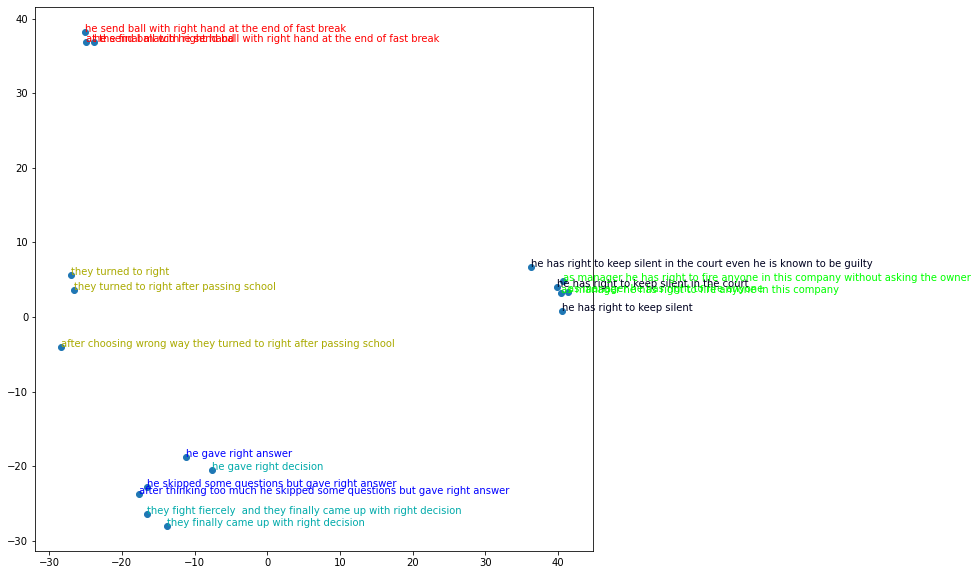

,he send ball with right hand,they turned to right,as manager he has right to fire anyone,he has right to keep silent,he gave right answer,he gave right decision,he send ball with right hand at the end of fast break,they turned to right after passing school,as manager he has right to fire anyone in this company,he has right to keep silent in the court,he skipped some questions but gave right answer,they finally came up with right decision,at the final match he send ball with right hand at the end of fast break,after choosing wrong way they turned to right after passing school,as manager he has right to fire anyone in this company without asking the owner,he has right to keep silent in the court even he is known to be guilty,after thinking too much he skipped some questions but gave right answer,they fight fiercely and they finally came up with right decision
he send ball with right hand,1.000,0.704,-0.473,-0.526,-0.441,-0.597,1.000,0.651,-0.475,-0.457,-0.361,-0.513,1.000,0.419,-0.441,-0.382,-0.349,-0.421
they turned to right,0.704,1.000,-0.959,-0.974,0.327,0.150,0.708,0.997,-0.959,-0.954,0.408,0.249,0.718,0.940,-0.948,-0.925,0.420,0.348
as manager he has right to fire anyone,-0.473,-0.959,1.000,0.998,-0.583,-0.425,-0.478,-0.977,1.000,1.000,-0.651,-0.514,-0.490,-0.998,0.999,0.995,-0.661,-0.600
he has right to keep silent,-0.526,-0.974,0.998,1.000,-0.531,-0.368,-0.531,-0.988,0.998,0.997,-0.603,-0.460,-0.543,-0.993,0.995,0.987,-0.613,-0.550
he gave right answer,-0.441,0.327,-0.583,-0.531,1.000,0.983,-0.436,0.394,-0.580,-0.597,0.996,0.997,-0.423,0.630,-0.611,-0.661,0.995,1.000
he gave right decision,-0.597,0.150,-0.425,-0.368,0.983,1.000,-0.592,0.220,-0.423,-0.441,0.964,0.995,-0.581,0.479,-0.457,-0.514,0.960,0.979
he send ball with right hand at the end of fast break,1.000,0.708,-0.478,-0.531,-0.436,-0.592,1.000,0.655,-0.480,-0.462,-0.356,-0.508,1.000,0.424,-0.446,-0.387,-0.344,-0.416
they turned to right after passing school,0.651,0.997,-0.977,-0.988,0.394,0.220,0.655,1.000,-0.977,-0.973,0.472,0.318,0.666,0.962,-0.968,-0.950,0.484,0.414
as manager he has right to fire anyone in this company,-0.475,-0.959,1.000,0.998,-0.580,-0.423,-0.480,-0.977,1.000,1.000,-0.649,-0.512,-0.492,-0.998,0.999,0.995,-0.659,-0.598
he has right to keep silent in the court,-0.457,-0.954,1.000,0.997,-0.597,-0.441,-0.462,-0.973,1.000,1.000,-0.664,-0.529,-0.475,-0.999,1.000,0.997,-0.674,-0.614


In [35]:
right_sentences = right_sentences_short + right_sentences_medium + right_sentences_long

keyword = ["right"]

word_embeddings,_,x_reduced = reduce_dim_draw( right_sentences,keyword,tokenizer,bert_model,color_by="index6")

draw_inner_cosine(x_reduced,right_sentences)
